# Introducción
El conjunto de datos a utilizar es "Heart Disease UCI". Este conjunto de datos contiene la información de 303 pacientes, de los cuales se registraron las siguientes variables:
1.  Edad del paciente en años.
2.  Sexo del paciente (0 si es mujer, 1 si es hombre).
3.  Tipo de dolor de pecho (valores 0, 1, 2, 3).
4.  Presión arterial sistólica en reposo (en mmHg al ingreso en el hospital).
5.  Colesterol sérico en mg/dL.
6.  Glucemia mayor a 120mg/dL (1 si ocurre, 0 si no).
7.  Resultados electrocardiográficos en reposo (valores 0, 1, 2).
8.  Frecuencia cardíaca máxima alcanzada (medida en latidos por minuto).
9.  Angina inducida por ejercicio (1 si ocurre, 0 si no).
10. "oldpeak": Depresión del segmento ST inducida por el ejercicio en relación con el reposo.
11.  Pendiente del segmento ST pico del ejercicio (valores 0, 1, 2).
12.  Número de vasos principales (0-3) coloreados por la floración.
13.  Talasemia: 3 = normal, 6 = defecto fijo, 7 = defecto reversible.

**Objetivo:** Analizar los datos y determinar la presencia de enfermedades cardíacas en los pacientes. La variable objetivo está codificada como 1 si el paciente presenta enfermedades cardíacas y 0 en caso contrario.


In [2]:
## Importamos las bibliotecas necesarias
import torch
import torch.nn as nn
import torchvision
import torch.utils.data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
filename = 'heart.csv'
dataheart = pd.read_csv(filename, header = 0)
print(dataheart.shape)  ## 303 observaciones, 14 variables
dataheart.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [82]:
## Vemos la dimension del dataset y el tamaño de la muestra
samples, n_features = dataheart.to_numpy().shape
print(samples, n_features)  ## 303 datos, 14 variables 

## Extraemos el numero de clases de la variable objetivo
clases = np.sort(dataheart['target'].unique())
print(clases)   ## Existen dos clases como ya se habia establecido

303 14
[0 1]


#Análisis estadístico de los datos
Antes de comenzar con el ajuste de la red neuronal, es importante hacer un análisis exploratorio de los datos para tener una idea de la distribución, medidas de tendencia central y dispersión y correlación con el fin de tener información del comportamiento de las variables.

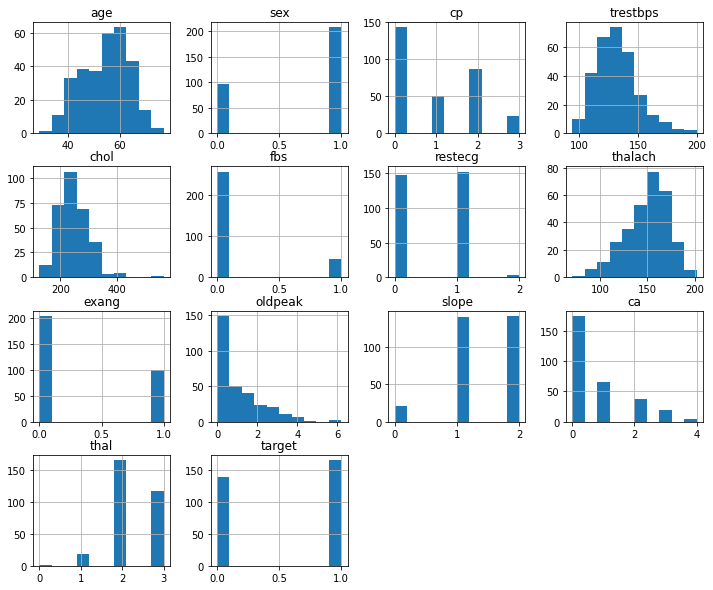

In [7]:
##Histogramas y gráficos de barras

%matplotlib inline
dataheart.hist(figsize=[12,10])
plt.show() 

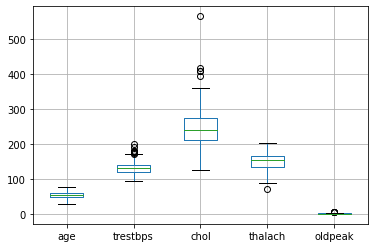

In [8]:
## Boxplot de las variables continuas

dataheart.boxplot(column=['age','trestbps','chol','thalach','oldpeak'])

Podemos ver que existen valores atípicos extremos en la variable de colesterol. Sin embargo, al ser una cantidad pequeña podría ser que no representen riesgos al momento del ajuste de la red.

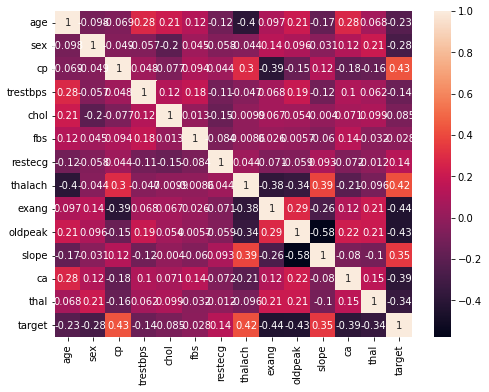

In [9]:
## Matriz de correlacion
matrix_corr = dataheart.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_corr, annot=True)
plt.show()

Para comenzar a trabajar con la implementación de la red, es necesario partir a todo el conjunto de datos en dos partes: el conjunto de prueba y el conjunto de entrenamiento. Tomaremos 75% para prueba y 25% de entrenamiento.

In [83]:
miau = np.random.rand(len(dataheart)) < 0.75
training_data = dataheart[miau]
test_data = dataheart[~miau]
print(training_data.shape)  ##Nos quedamos 233 de entrenamiento
print(test_data.shape)      ## 70 de prueba

(233, 14)
(70, 14)


Ya que tenemos muy pocos datos y la mayoría de las covariables explicativas son categóricas, no haremos transformaciones a los datos, como lo sería escalarlos. 

#Clase Dataset


In [84]:
from torch.utils.data import Dataset

class DataframeDataset(Dataset):

  def __init__(self, data, y_name, transform=None, target_transform=None):
    '''
      data: pandas.DataFrame
    '''
    self.Y = torch.tensor(data[y_name].to_numpy(), dtype=torch.long)
    aux = data.drop(y_name, axis=1).to_numpy()
    self.X = torch.from_numpy(aux).to(dtype=torch.float32)
    self.transform = transform
    self.target_transform = target_transform 

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)
    return x, y

In [85]:
## Transformamos los datos a objetos de la clase dataset
train_dataset = DataframeDataset(training_data, y_name='target')
test_dataset = DataframeDataset(test_data, y_name='target')

#Validación 
Para la validación utilizaremos la siguiente partición


In [86]:
evens = list(range(0, len(test_dataset), 2))
odds = list(range(1, len(test_dataset), 2))
val_dataset = torch.utils.data.Subset(test_dataset, evens)
test_dataset = torch.utils.data.Subset(test_dataset, odds)

In [87]:
## Las cardinalidades de los conjuntos de prueba, validacion y entrenamiento son
n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

print("Entrenamiento: ", n_train, "Prueba ", n_test, "Validacion ", n_val)


Entrenamiento:  233 Prueba  35 Validacion  35


#Dataloader
Utilizaremos un tamaño de batch de 64.

In [91]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #Shuffle para tomar los batches
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)      # de forma aleatoria
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [92]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 13])
Labels batch shape: torch.Size([64])


#Declaración de la red neuronal
Utilizaremos una red neuronal con
1. $k$ Tamaño de los mini-batches = 64
2. $p$ número de covariables = 13
3. $c$ número de clases = 2

Para declarar la red usaremos dos capas ocultas con funciones _relu_ y ya que es clasificación, utilizaremos la función _softmax_ (esta se encontrará de manera tácita en el criterio de _Cross Entropy Loss_).

In [93]:
n_features = n_features -1  ##Restamos 1 porque esa es la variable respuesta
n_clases = len(clases)   ## 2 clases
N = [64, 64]

print(n_clases, n_features)

2 13


In [94]:
from collections import OrderedDict
from torch import nn

relu = nn.ReLU()

# Definimos la arquitectura del modelo de la red
modelo = nn.Sequential(OrderedDict([
    ('z1', nn.Linear(n_features, 64)),
    ('h1', relu),
    ('z2', nn.Linear(64, 64)),
    ('h2', relu),
    ('z3', nn.Linear(64, n_clases)),
]))

In [95]:
## Hacemos una instancia rapida del modelo
x = torch.randn(1, n_features)
modelo(x)

tensor([[0.0098, 0.1479]], grad_fn=<AddmmBackward>)

In [96]:
## Imprimimos el modelo para ver su forma
print(modelo)  #Dos capas internas con funciones ReLU y una capa de salida con dos clases
                #En todas vemos el sesgo activado

Sequential(
  (z1): Linear(in_features=13, out_features=64, bias=True)
  (h1): ReLU()
  (z2): Linear(in_features=64, out_features=64, bias=True)
  (h2): ReLU()
  (z3): Linear(in_features=64, out_features=2, bias=True)
)


In [97]:
## Instanciamos la Cross Entropy Loss
CEL = nn.CrossEntropyLoss()
yhat = torch.rand(3, 5, requires_grad = True)  ##activamos requieres_grad para los gradientes
y = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = CEL(yhat, y)
print(loss)

tensor(1.6140, grad_fn=<NllLossBackward>)


In [98]:
##Fijamos el criterio de minimizacion y el optimizador
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=3e-3, weight_decay=0.0001)

#Entrenamiento
Dado que ya construimos la red con la arquitectura mencionada, fijamos los criterios de optimización, la función de pérdida, el modelo y el dataloader, podemos entrenarla con el conjunto de datos de entrenamiento previamente definido.

In [99]:
## Barra de progreso
from tqdm import tqdm

outer = tqdm(total=3, desc='Epoch', position=0)
for ii in range(3):
    inner = tqdm(total=5, desc='Batch', position=1)
    for jj in range(2):
        #do your training
        inner.update(1)
    outer.update(1)

Epoch: 100%|██████████| 3/3 [07:20<00:00, 146.80s/it]

Batch:  40%|████      | 2/5 [07:20<11:00, 220.19s/it]

Batch:  40%|████      | 2/5 [00:00<00:00, 88.64it/s]

Batch:  40%|████      | 2/5 [00:00<00:00, 83.81it/s]


In [100]:
##definimos el ajuste del modelo para los pasos que se haran por epoca

import torch.nn.functional as F

def modelfit(modelo, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0  ##Iniciamos la perdida en cero
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    if train:
      optimizer.zero_grad() # Para no guardar el gradiente pasado
    pred = modelo(X) # forward pass 
    loss = criterion(pred, Y) # evaluacion para la prediccion respecto a la CEL
    if train:
      loss.backward() # calculo de derivadas
      optimizer.step() # pasos de optimizacion

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)   ##Utilizamos la softmax para la prediccion 
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    accuracy = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), accuracy='{:.4f}'.format(accuracy))
    pbar.update(Y.shape[0])
  return avg_loss, accuracy

In [108]:
## Definimos el numero de epocas para la red
import time

EPOCAS = 500   ## 500 epocas
train_time = 0

epoch_loss = []  #Inicializamos todo como listas vacias donde iremos 
epoch_acc = []   #Guardando los datos

val_loss = []
val_acc = []

In [109]:
for epoca in range(EPOCAS):
  start_time = time.time()
  with tqdm(total=n_train, position=0) as pbar_train:
    pbar_train.set_description(f'Epoch {epoca + 1}/'+str(EPOCAS)+' - train')
    pbar_train.set_postfix(avg_loss='0.0', accuracy='0.0')
    loss_train, accuracy_train = modelfit(modelo, train_dataloader, optimizer, criterion, pbar_train)
    train_time +=  time.time() - start_time
  with tqdm(total=n_val, position=0) as pbar_val:
    pbar_val.set_description(f'Epoch {epoca + 1}/'+str(EPOCAS)+' - val')
    pbar_val.set_postfix(avg_loss='0.0', accuracy='0.0')
    loss_val, accuracy_val = modelfit(modelo, val_dataloader, optimizer, criterion, pbar_val, train=False)

  epoch_loss.append(loss_train)
  epoch_acc.append(accuracy_train)

  val_loss.append(loss_val)
  val_acc.append(accuracy_val)

print("\n --- %s seconds ---", train_time)

Epoch 500/500 - val: 100%|██████████| 35/35 [00:00<00:00, 3568.15it/s, accuracy=0.7143, avg_loss=2.6867]


 --- %s seconds --- 32.674497842788696


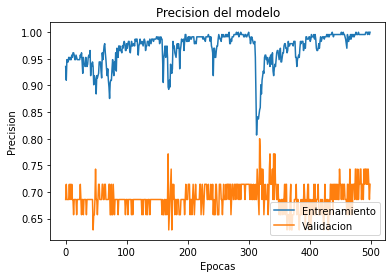

In [110]:
#graficamos la precision con respecto al tiempo

plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validacion'], loc='lower right')
plt.show()

Se puede observar que existe una gran diferencia entre la precisión en el entrenamiento y en la validación desde el inicio. Además, algo muy singular es que en la época 320 (aproximadamente) la precisión del entrenamiento decae drásticamente. 

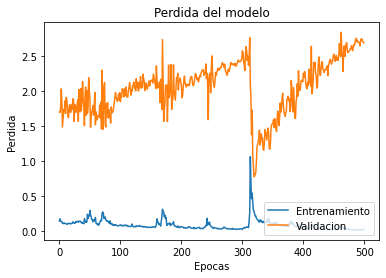

In [111]:
## Veamos la perdida del entrenamiento y la validacion
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validacion'], loc='lower right')
plt.show()

En este caso podemos ver que también las pérdidas están muy alejadas entre sí. La validación muestra una pérdida fuerte desde el inicio, y aunque decae en un punto, vuelve a subir muy rápidamente. Por otro lado, la pérdida del entrenamiento se mantiene pegada al cero, y aunque tiene una subida repentina, vuelve a bajar con el tiempo.

#Prueba de la red
Ya que se ha entrenado la red, es momento de utilizar el conjunto de prueba antes definido, con el fin de ver la precisión y la pérdida media del modelo.

In [117]:
running_loss = 0.0
correct = 0
total = 0
modelo.eval()
for i, data in enumerate(test_dataloader, 0):
    X, Y = data   
    pred = modelo(X)
    loss = criterion(pred, Y)
    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    accuracy = correct/total
        
print('Precision: {}, Perdida: {}'.format(accuracy, avg_loss))

Precision: 0.6857142857142857, Perdida: 2.194931937722913


Podemos ver una precisión  del 68% y una pérdida de 2.1949. Si bien, la precisión es mayor a 0.5, no es una precisión cercana a 1. Esto puede deberse al tamaño del conjunto de datos es muy pequeño. Al tener tan solo 303 datos, se cuenta con muy pocos datos para entrenar y para probar, por lo cual la red no aprende tan bien como esperaríamos, y tampoco tiene un buen rendimiento.

Podría ajustarse un modelo de regresión logística o árboles CART para comparar las precisiones y pérdidas de cada modelo. 

